In [3]:
from moredata.datasets import get_path
from moredata import Converter
import pandas as pd

df = pd.read_csv(get_path("airbnb-berlin"))
df = df.loc[(~df['latitude'].isna()) & (~df['longitude'].isna())]
df.to_json('./data/airbnb-berlin.json', orient='records')

/home/thomas/anaconda3/envs/moredata-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (0,22,36,41,45,46,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
import moredata

data = moredata.models.JsonData(data_file='./data/airbnb-berlin.json',parser=moredata.parser.parse_document)

osm_enricher = moredata.enricher.osm.OSMPlacesConnector(place_name="Berlin, DE", files=['./data/tourism.csv.gz'], radius=50, geometry_intersected=True)

data_enriched = osm_enricher.enrich(data)

moredata.utils.write_json_generator_to_json("./data/airbnb-berlin-enriched", data_enriched, 100000)

TypeError: __init__() got an unexpected keyword argument 'data_type'

In [ ]:
import pandas as pd
df_enriched = pd.read_json('./data/airbnb-berlin-enriched-0.json', orient='records')

In [ ]:
df_enriched.loc[(~df_enriched['local'].isna()) & (~df_enriched['geometry_intersected'].isna()), 'near_tourism_places'] = 'Yes'
df_enriched['near_tourism_places'] = df_enriched['near_tourism_places'].fillna('No')

In [ ]:
df_enriched['price'] = df_enriched['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [8]:
df_enriched['price'].describe()

count    19858.000000
mean        70.776866
std        120.384857
min          0.000000
25%         35.000000
50%         50.000000
75%         80.000000
max       8000.000000
Name: price, dtype: float64

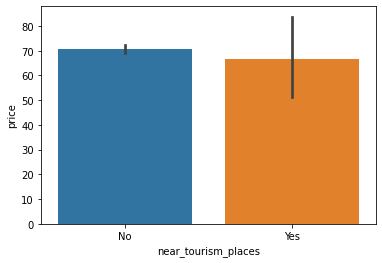

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(y="price", x="near_tourism_places", data=df_enriched)
plt.show()

In [10]:
import folium
from moredata.utils import geodesic_point_buffer
from shapely.geometry.polygon import Polygon
from shapely import wkt
import geopandas as gpd
from util import add_categorical_legend

poi = df_enriched.loc[(~df_enriched['geometry_intersected'].isna())][['geometry_intersected', 'latitude', 'longitude']] \
                    .reset_index().iloc[[5]]

polygon = wkt.loads(poi['geometry_intersected'][5][0])
latitude = poi['latitude'].squeeze()
longitude = poi['longitude'].squeeze()

shp = Polygon(geodesic_point_buffer(latitude, longitude, 50))

m = folium.Map(location=[latitude, longitude], zoom_start=17, tiles='CartoDB positron')
folium.Marker(
    [latitude, longitude], icon=folium.Icon(color="blue"), popup='Point of Interest'
).add_to(m)

sim_geo = gpd.GeoSeries.from_wkt([shp.wkt])
geo_j = sim_geo.to_json()

geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'grey'})
geo_j.add_to(m)
    
sim_geo = gpd.GeoSeries(polygon)
geo_j = sim_geo.to_json()

geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'black', 'color': 'black'})
geo_j.add_to(m)

m = add_categorical_legend(m, 'Polygons',
                             colors = ['blue','black'],
                           labels = ['Point of Interest', 'Tourism Place'])

m